## Binary classification with ShallowConvNet

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset

### 1. Import libraries

In [2]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [3]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data
- We train using the training set and save the model that gives the best performance on the validation set

In [4]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. ShallowConvNet model

- Paper: https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
- Pytorch conversion from keras implementation https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
- Another useful link: https://github.com/TNTLFreiburg/braindecode/tree/master/braindecode
- Pytorch implementation of the Shallow Convolutional Network as described in Schirrmeister et. al. (2017), Human Brain Mapping.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions.

- Assumes the input is a 5-second EEG signal sampled at 500Hz. 

- Note that we use the max_norm constraint on all convolutional layers, as well as the classification layer.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions. Instead, they can be implemented using hooks or by manually enforcing the constraint during the forward pass or after updating the weights. 
- Model was developed with hyperparameters from original paper
- examples are in: https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html#model-training

In [5]:
import torch
import torch.nn as nn

def max_norm(layer, max_value, axis=0):
    with torch.no_grad():
        norm = layer.weight.norm(2, axis, keepdim=True)
        desired = torch.clamp(norm, 0, max_value)
        scale = desired / (1e-8 + norm)
        layer.weight.data *= scale

class ShallowConvNet(nn.Module):
    def __init__(self, nb_classes, Chans=59, Samples=2500, dropoutRate=0.5):
        super(ShallowConvNet, self).__init__()
        self.Samples=Samples       
        # First Conv2D layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=40, kernel_size=(1, 25), padding=0)     
        # Second Conv2D layer
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(Chans, 1), bias=False)     
        # Batch Normalization
        self.batchnorm = nn.BatchNorm2d(num_features=40, eps=1e-05, momentum=0.9)     
        # Average Pooling
        self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))     
        # Dropout
        self.dropout = nn.Dropout(p=dropoutRate)    
        # Fully Connected Layer
        self.fc = nn.Linear(in_features=40* ((Samples - 24-74) // 15+1), out_features=nb_classes)
        
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
         # Size: (batch_size, 1, Chans, Samples)

        # First convolutional layer
        x = self.conv1(x)
        max_norm(self.conv1, 2.0, axis=(0, 1, 2))
        # Size: (batch_size, 40, Chans, Samples - 24)
        
        # Second convolutional layer
        x = self.conv2(x)
        max_norm(self.conv2, 2.0, axis=(0, 1, 2))
        # Size: (batch_size, 40, 1, Samples - 24)

        # Batch normalization
        x = self.batchnorm(x)     
        # Square activation
        x = torch.square(x)   
        
        # Average pooling
        x = self.pool(x) 
        # Size: (batch_size, 40, 1, (Samples - 24-74) // 15+1)
        
        # Log activation
        x = torch.log(x)   
        # Dropout
        x = self.dropout(x)  
        # Flatten
        x = x.view(-1, int(40* ((self.Samples - 24-74) // 15+1))) 
        # Size: (batch_size, 40 * (Samples - 24-74) // 15+1)

        # Fully connected layer
        x = self.fc(x)
        max_norm(self.fc, 0.5, axis=0)       
        
        return x

### 5. Initialize model

In [6]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = ShallowConvNet(nb_classes=2, Chans=n_chan, Samples=n_datalength, dropoutRate=0.5)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [7]:
#batch_size = 8#1
batch_size = 64 # from their doc website
num_epochs = 70 # utilized from CNN model of Oh et al. 2018
#num_epochs = 4 # from their website. This resulted in very littile training.
#lrate=5e-4
lrate=0.0625 * 0.01 # from their doc website
weight_decay = 0 # from their website
patience=80
# Define loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=lrate,weight_decay=weight_decay)
#criterion = nn.NLLLoss() # from their website
optimizer = optim.AdamW(model.parameters(), lr=lrate,weight_decay=weight_decay) # from their website
cnn_modelfullpath=os.path.join(cnn_modelpath,'shallownet.pt')

random_seed=42

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [8]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [9]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/70: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


model state saved with validation accuracy: 50.7246


Epoch 7/70: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


model state saved with validation accuracy: 51.4493


Epoch 8/70: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


model state saved with validation accuracy: 53.6232


Epoch 12/70: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


model state saved with validation accuracy: 63.0435


Epoch 16/70: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


model state saved with validation accuracy: 65.2174


Epoch 24/70: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


model state saved with validation accuracy: 68.1159


Epoch 25/70: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


model state saved with validation accuracy: 70.2899


Epoch 31/70: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


model state saved with validation accuracy: 73.1884


Epoch 37/70: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


model state saved with validation accuracy: 75.3623


Epoch 54/70: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


model state saved with validation accuracy: 78.9855


Epoch 70/70: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


### 9. Inspect training process

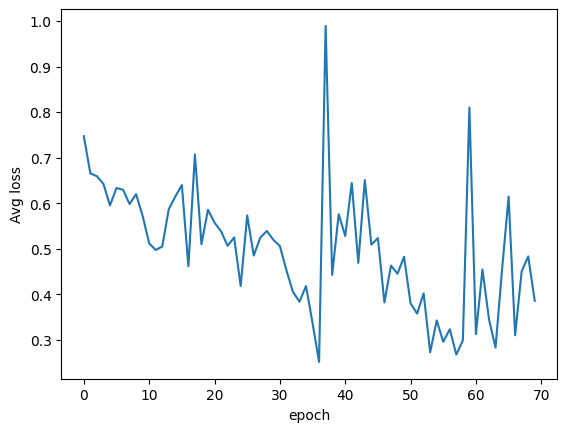

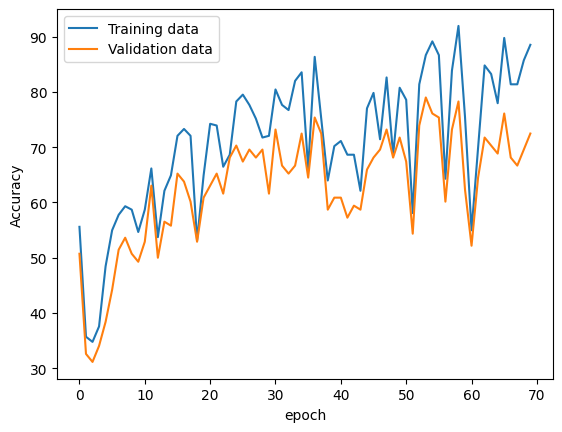

In [10]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [11]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 86.6460
Confusion Matrix:
[[152  16]
 [ 27 127]]
Accuracy: 86.64596273291926
Precision: 88.81118881118881
Sensitivity (Recall): 82.46753246753246
Specificity: 90.47619047619048
F1 Score: 0.8552188552188552
AUC Score: 0.962430426716141


Validation Binary Accuracy: 78.9855
Confusion Matrix:
[[60 12]
 [17 49]]
Accuracy: 78.98550724637681
Precision: 80.32786885245902
Sensitivity (Recall): 74.24242424242425
Specificity: 83.33333333333334
F1 Score: 0.7716535433070867
AUC Score: 0.876473063973064


Test Binary Accuracy: 79.3478
Confusion Matrix:
[[40  8]
 [11 33]]
Accuracy: 79.34782608695652
Precision: 80.48780487804879
Sensitivity (Recall): 75.0
Specificity: 83.33333333333334
F1 Score: 0.7764705882352942
AUC Score: 0.8309659090909091
Completed
